In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from exp.nb_04 import *

## Initial setup

In [3]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [6]:
learn = create_learner(get_model, loss_func, data)

In [7]:
run = Runner(cbs=[AvgStatsCallback([accuracy])])

In [8]:
run.fit(3, learn)

train: [0.665509921875, tensor(0.8028)]
valid: [0.30456748046875, tensor(0.9124)]
train: [0.30276005859375, tensor(0.9110)]
valid: [0.2522939208984375, tensor(0.9281)]
train: [0.23848375, tensor(0.9302)]
valid: [0.2185429443359375, tensor(0.9362)]


In [9]:
learn = create_learner(partial(get_model, lr=.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

In [10]:
run.fit(3, learn)

train: [0.767665078125, tensor(0.7975)]
valid: [0.3599838134765625, tensor(0.8994)]
train: [0.3512898046875, tensor(0.8996)]
valid: [0.30167353515625, tensor(0.9121)]
train: [0.301365234375, tensor(0.9139)]
valid: [0.2613446533203125, tensor(0.9253)]


In [11]:
def get_model_func(lr=.5): return partial(get_model, lr=lr)

## Annealing

In [49]:
class Recorder(Callback):
    def begin_fit(self): self.lrs, self.losses = [], []
        
    def after_batch(self): 
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

In [13]:
class ParamScheduler(Callback):
    _order = 1
    
    def __init__(self, pname, sched_func):
        self.pname, self.sched_func = pname, sched_func
        
    def set_param(self): 
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs / self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [15]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos * (end - start)
    return partial(_inner, start, end)

In [16]:
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos * (end - start)

In [18]:
f = sched_lin(1, 2)
f(0), f(.5), f(1)

(1, 1.5, 2)

In [22]:
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos): return start
@annealer
def sched_exp(start, end, pos): return start * (end / start)**pos

In [29]:
torch.Tensor.ndim = property(lambda x: len(x.shape))

In [32]:
torch.Tensor.ndim??

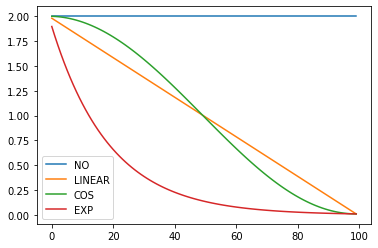

In [33]:
annealings = ['NO', 'LINEAR', 'COS', 'EXP']
fns = [sched_no, sched_lin, sched_cos, sched_exp]

a = torch.arange(0, 100)
p = torch.linspace(0.01, 1, 100)
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
    
plt.legend();

In [34]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, dim=0)
    
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos - pcts[idx])/(pcts[idx+1] - pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [35]:
sched = combine_scheds([.3, .7], [sched_cos(.3, .6), sched_cos(.6, .2)])

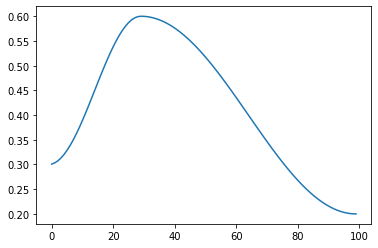

In [37]:
plt.plot(a, [sched(o) for o in p]);

In [51]:
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [52]:
learn = create_learner(get_model_func(3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [41]:
run.fit(3, learn)

train: [0.78673671875, tensor(0.7791)]
valid: [0.3707511962890625, tensor(0.8877)]
train: [0.302224765625, tensor(0.9122)]
valid: [0.237451953125, tensor(0.9307)]
train: [0.24191982421875, tensor(0.9304)]
valid: [0.215645068359375, tensor(0.9398)]


In [53]:
run.fit(3, learn)

train: [0.77957484375, tensor(0.7808)]
valid: [0.328704345703125, tensor(0.9046)]
train: [0.299473671875, tensor(0.9117)]
valid: [0.2368375, tensor(0.9317)]
train: [0.23488119140625, tensor(0.9322)]
valid: [0.2081812744140625, tensor(0.9404)]


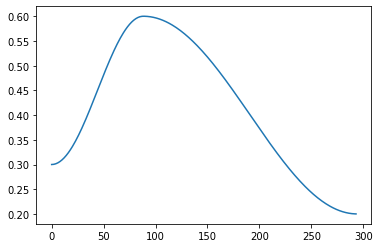

In [55]:
run.recorder.plot_lr()

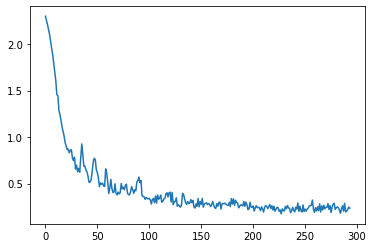

In [58]:
run.recorder.plot_loss()

## Discrimitive learning rates

In [60]:
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []
        
    def after_batch(self):
        if not self.in_train: return
        for pg, lr in zip(self.opt.param_groups, self.lrs):
            lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:-skip_last])

In [62]:
class ParamScheduler(Callback):
    _order = 1
    
    def __init__(self, pname, sched_funcs): 
        self.pname, self.sched_funcs = pname, sched_funcs
        
    def begin_fit(self): 
        if not isinstance(self.sched_funcs, (list, tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)
            
    def set_param(self): 
        assert len(self.opt.param_groups) == len(self.sched_funcs)
        for pg, f in zip(self.opt.param_groups, self.sched_funcs):
            pg[self.pname] = f(self.n_epochs / self.epochs)
        
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [66]:
m = data.train_ds.x.shape[1]
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, data.c))

In [72]:
wgts, biases = [], []
for l in model:
    if hasattr(l, 'weight'): wgts.append(l.weight)
    if hasattr(l, 'bias'): biases.append(l.bias)

In [70]:
def pg_dicts(pgs): return [{'params':o} for o in pgs]

In [78]:
pgs = pg_dicts((wgts, biases))
opt = optim.SGD(pgs, lr=.1)
learn = Learner(model, opt, loss_func, data)

In [79]:
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

In [80]:
phases = [.3, .7]
sched_w = combine_scheds(phases, cos_1cycle_anneal(0.3, 0.6, 0.2))
sched_b = combine_scheds(phases, cos_1cycle_anneal(0.9, 1.8, 0.6))

In [81]:
def create_scheds(pct_first, sched_func, starts, highs, ends):
    phases = [pct_first, 1 - pct_first]
    return [combine_scheds(phases, [sched_func(s, h), sched_func(h, e)])
            for s, h, e in zip(starts, highs, ends)]

In [82]:
scheds = create_scheds(.3, sched_cos, [.3, .9], [.6, 1.8], [.2, .6])

In [83]:
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        partial(ParamScheduler, 'lr', scheds)]

In [84]:
run = Runner(cb_funcs=cbfs)

In [85]:
run.fit(3, learn)

train: [0.7692346875, tensor(0.7883)]
valid: [0.321193017578125, tensor(0.9080)]
train: [0.312442109375, tensor(0.9073)]
valid: [0.2382891845703125, tensor(0.9310)]
train: [0.24049955078125, tensor(0.9307)]
valid: [0.2145664794921875, tensor(0.9401)]


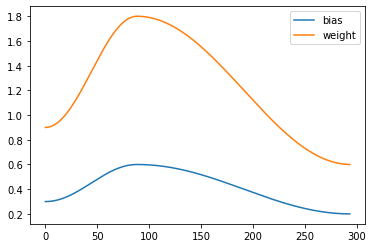

In [96]:
plt.plot(run.recorder.lrs[0], label='bias');
plt.plot(run.recorder.lrs[1], label='weight');
plt.legend();

# fin